## NEXRAD Data Download and Analysis
Karl Schneider (kps5442@psu.edu)

In [1]:
import tempfile
from datetime import datetime, timedelta
import nexradaws


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



#### Data Download
An example of downloading NEXRAD Level 2 radar data for a particular time of interest using the nexradaws python module.  
https://nexradaws.readthedocs.io/en/latest/

In [2]:
# Download test data - look for files in window of 10 min before time of interest and grab most recent file
conn = nexradaws.NexradAwsInterface()
site = 'KCCX'
time = datetime(2017, 3, 3, 18, 30)
scans = conn.get_avail_scans_in_range(time-timedelta(minutes=10), time, site)

In [3]:
scans

[<AwsNexradFile object - 2017/03/03/KCCX/KCCX20170303_182436_V06>]

In [4]:
# Download data to a temporary directory
tmpdir = tempfile.mkdtemp()
download = conn.download(scans[-1], tmpdir)

Downloaded KCCX20170303_182436_V06
1 out of 1 files downloaded...0 errors


In [5]:
# Show the downloaded file
download.success

[<LocalNexradFile object - /tmp/tmpyvpxedbu/KCCX20170303_182436_V06>]

----

#### Creating a Plot
An example of reading a NEXRAD Level 2 file using pyart and plotting on a base map using cartopy.

In [6]:
import pyart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import USCOUNTIES

In [7]:
# Open the file
radar = pyart.io.read(download.success[0].filepath)

In [8]:
# See documentation at https://arm-doe.github.io/pyart/API/generated/pyart.core.Radar.html for info we can pull out of radar object
radar

In [9]:
radar.elevation

{'units': 'degrees',
 'standard_name': 'beam_elevation_angle',
 'long_name': 'elevation_angle_from_horizontal_plane',
 'axis': 'radial_elevation_coordinate',
 'comment': 'Elevation of antenna relative to the horizontal plane',
 'data': array([ 0.6838989,  0.703125 ,  0.703125 , ..., 19.59961  , 19.59961  ,
        19.59961  ], dtype=float32)}

In [10]:
# Get the first sweep - this will usually be the lowest elevation angle
sweep_num = 0
sweep_0 = radar.get_slice(sweep_num)

# This is the end time of the sweep
valid_time = pyart.util.datetimes_from_radar(radar)[radar.get_end(sweep_num)]

# Latitude and longitude arrays for creating a plot
lat, lon = radar.gate_latitude['data'][sweep_0], radar.gate_longitude['data'][sweep_0]

# Grab reflectivity values
ref = radar.fields['reflectivity']['data'][sweep_0]

# The location of the radar
radar_lat, radar_lon = radar.latitude['data'][0], radar.longitude['data'][0]

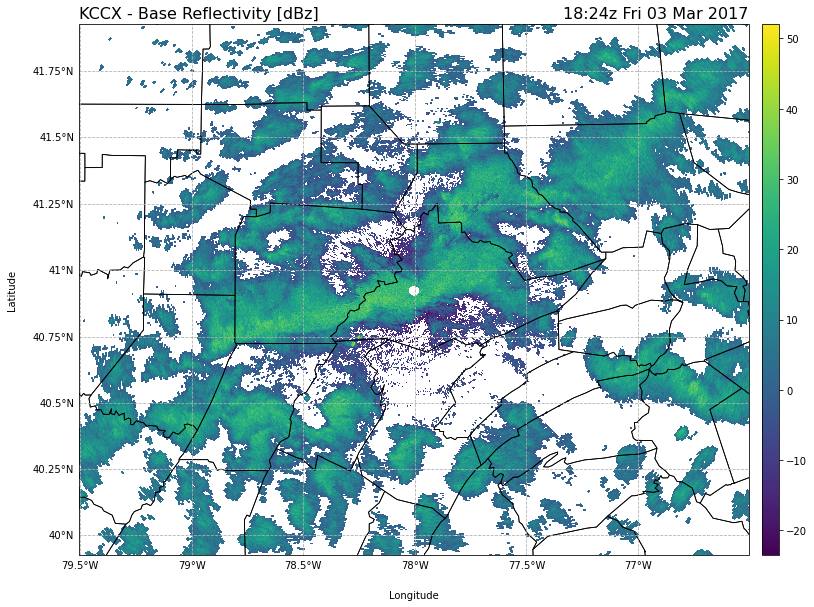

In [19]:
# The plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection=ccrs.Miller())
ax.set_extent([radar_lon-1.5, radar_lon+1.5, radar_lat-1, radar_lat+1], ccrs.PlateCarree())
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.8)
mesh = ax.pcolormesh(lon, lat, ref, transform=ccrs.PlateCarree(), shading='auto')

# Gridlines, labels, titles
g1 = ax.gridlines(linestyle='dashed', draw_labels=True)
g1.top_labels = False
g1.right_labels = False
ax.text(0.5, -0.075, 'Longitude', ha='center', va='center', transform=ax.transAxes)
ax.text(-0.1, 0.5, 'Latitude', ha='center', va='center', rotation=90, transform=ax.transAxes)
ax.set_title('{} - Base Reflectivity [dBz]'.format(site), loc='left', fontsize=16)
ax.set_title(valid_time.strftime('%H:%Mz %a %d %b %Y'), loc='right', fontsize=16)

# Colorbar
cbar_ax = ax.inset_axes([1.02, 0, 0.025, 1.0], transform=ax.transAxes)
plt.colorbar(mesh, cax=cbar_ax)